In [1]:
#!pip uninstall tensorflow keras

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install --upgrade pip
#!pip install TensorFlow
import sys
import os
import json
import pandas
import numpy
import optparse
#!pip install keras --upgrade
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict

In [2]:

data = pd.read_csv("C:/Users/saikr/Desktop/Q4/Time Series/Final Project/final_data_1970_2023.csv")
data.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Chicago,United States",1970-01-01,-0.7,-4.9,-2.5,-2.1,-9.9,-6.9,-5.0,82.8,...,NaN,NaN,NaN,1970-01-01T07:18:28,1970-01-01T16:29:58,0.80,Overcast,Cloudy skies throughout the day.,cloudy,"99999914819,99999994866"
1,"Chicago,United States",1970-01-02,-3.3,-6.7,-5.0,-8.5,-13.4,-10.4,-8.4,77.3,...,NaN,NaN,NaN,1970-01-02T07:18:32,1970-01-02T16:30:50,0.83,Overcast,Cloudy skies throughout the day.,cloudy,"99999914819,99999994866"
2,"Chicago,United States",1970-01-03,-7.9,-12.2,-9.7,-14.2,-21.6,-17.8,-13.3,75.1,...,NaN,NaN,NaN,1970-01-03T07:18:35,1970-01-03T16:31:44,0.86,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"99999914819,99999994866"
3,"Chicago,United States",1970-01-04,-2.9,-15.6,-8.4,-9.2,-21.7,-15.0,-11.6,77.8,...,NaN,NaN,NaN,1970-01-04T07:18:35,1970-01-04T16:32:39,0.90,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"99999914819,99999994866"
4,"Chicago,United States",1970-01-05,-4.4,-13.9,-8.5,-9.7,-24.4,-14.9,-15.7,58.0,...,NaN,NaN,NaN,1970-01-05T07:18:33,1970-01-05T16:33:36,0.93,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"99999914819,99999994866"


In [3]:
data = data[["datetime","tempmax","tempmin","temp"]]
data['datetime'] = pd.to_datetime(data['datetime'])
data.sort_values(by="datetime", inplace=True)
data_tmax = data[["datetime","tempmax"]]
data_tmin = data[["datetime","tempmin"]]
data_tavg = data[["datetime","temp"]]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19570 entries, 0 to 19569
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  19570 non-null  datetime64[ns]
 1   tempmax   19570 non-null  float64       
 2   tempmin   19570 non-null  float64       
 3   temp      19570 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 611.7 KB


In [5]:
data.head()

,datetime,tempmax,tempmin,temp
0,1970-01-01,-0.7,-4.9,-2.5
1,1970-01-02,-3.3,-6.7,-5.0
2,1970-01-03,-7.9,-12.2,-9.7
3,1970-01-04,-2.9,-15.6,-8.4
4,1970-01-05,-4.4,-13.9,-8.5


In [6]:
data.tail()

,datetime,tempmax,tempmin,temp
19565,2023-07-27,32.7,23.2,28.5
19566,2023-07-28,33.2,22.8,28.1
19567,2023-07-29,27.8,21.0,24.1
19568,2023-07-30,25.8,20.4,23.2
19569,2023-07-31,27.5,17.8,23.1


In [7]:
data.isnull().sum()

datetime    0
tempmax     0
tempmin     0
temp        0
dtype: int64

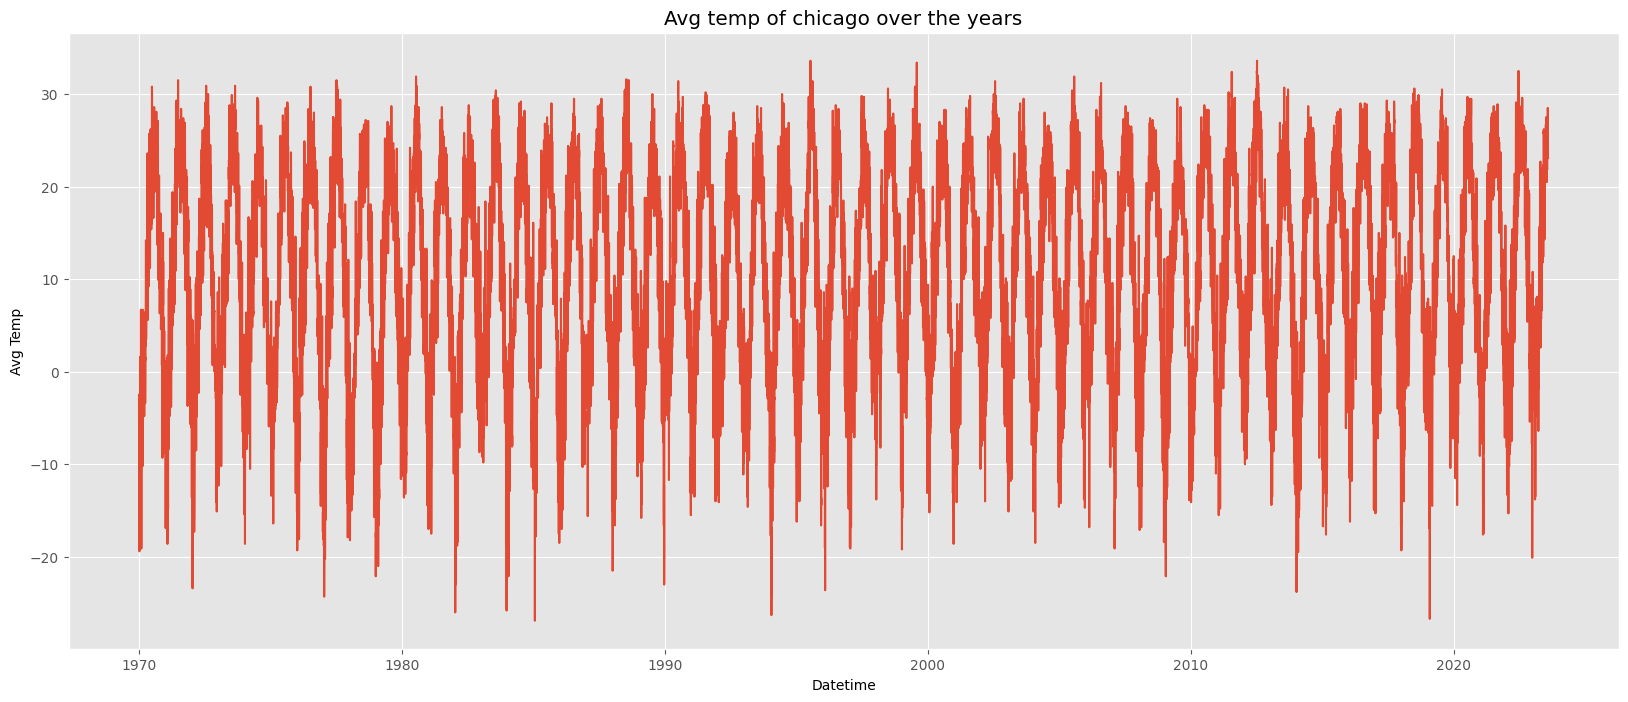

In [8]:

plt.style.use('ggplot')
plt.figure(figsize=(20, 8))
plt.plot(data["datetime"], data['temp'])
plt.xlabel('Datetime')
plt.ylabel('Avg Temp')
plt.title('Avg temp of chicago over the years')
plt.show()

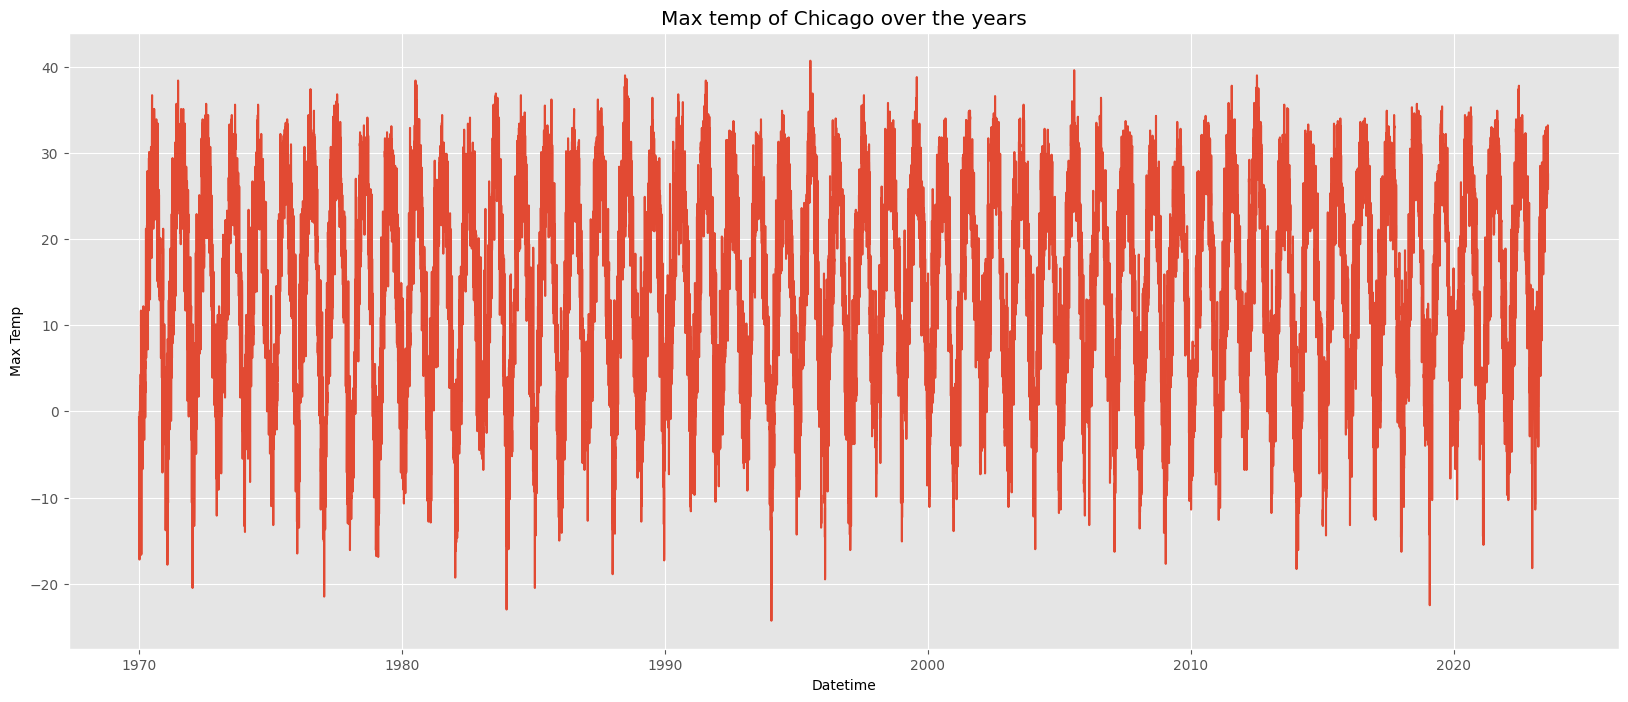

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(data["datetime"], data['tempmax'])
plt.xlabel('Datetime')
plt.ylabel('Max Temp')
plt.title('Max temp of Chicago over the years')
plt.show()

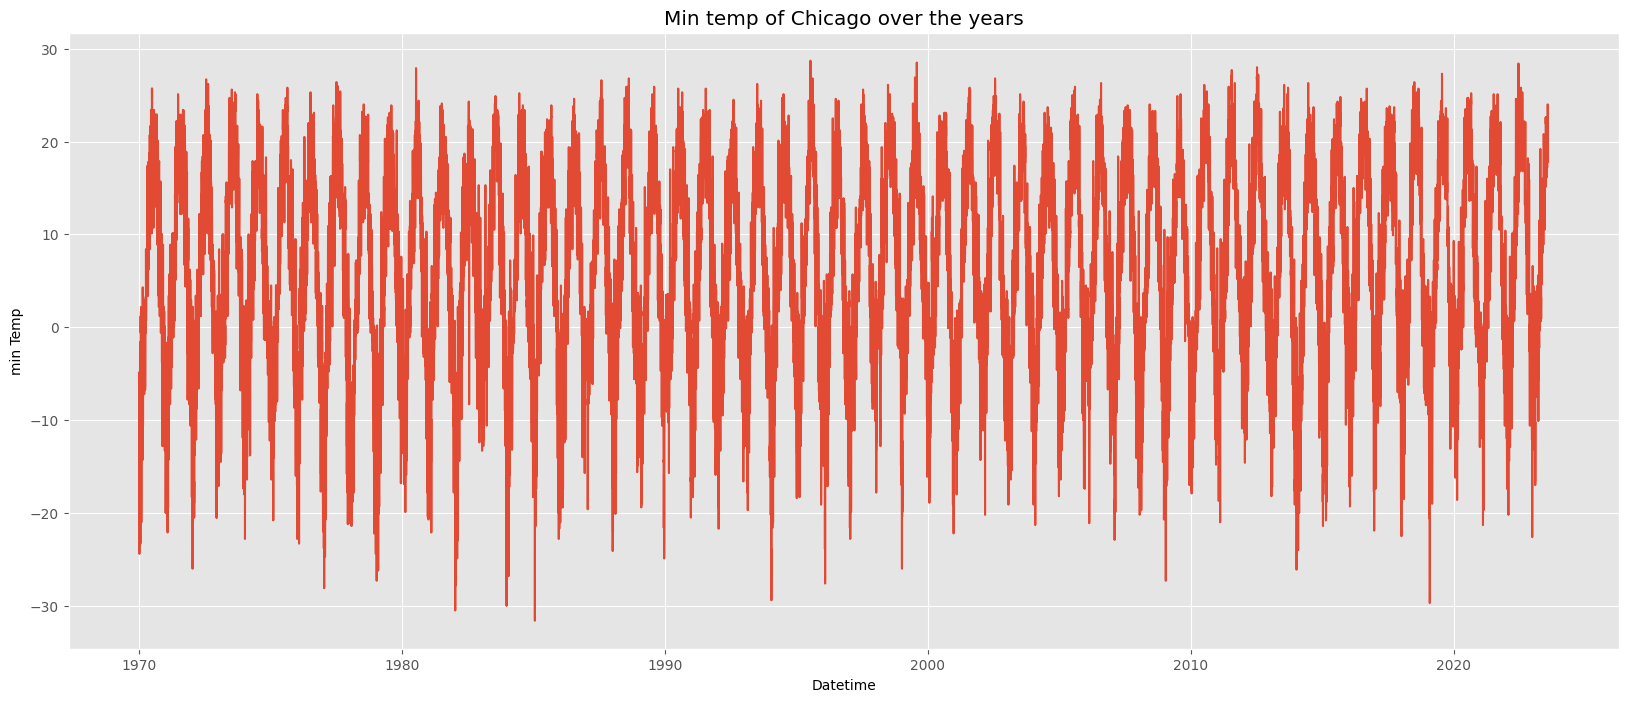

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(data["datetime"], data['tempmin'])
plt.xlabel('Datetime')
plt.ylabel('min Temp')
plt.title('Min temp of Chicago over the years')
plt.show()

In [11]:
from typing import Tuple
def create_data_for_NN(data: pandas.DataFrame, Y_var: str, lag: int, test_ratio: float
) -> Tuple[np.array, np.array, np.array, np.array]:
    y = data[Y_var].tolist()
    X, Y = [], []
    if len(y) - lag <= 0:
        X.append(y)
    else:
        for i in range(len(y) - lag):
            Y.append(y[i + lag])
            X.append(y[i : (i + lag)])

    X, Y = np.array(X), np.array(Y)
    # Reshaping the X array to an LSTM input shape
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    # Creating training and test sets
    X_train = X
    X_test = []
    Y_train = Y
    Y_test = []
    if test_ratio > 0:
        index = round(len(X) * test_ratio)
        X_train = X[: (len(X) - index)]
        X_test = X[-index:]
        Y_train = Y[: (len(X) - index)]
        Y_test = Y[-index:]
    return X_train, X_test, Y_train, Y_test

In [12]:
from sklearn.preprocessing import StandardScaler
def scale_values(X_train, X_test, Y_train, Y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    scaler = StandardScaler()
    Y_train_scaled = scaler.fit_transform(Y_train.reshape(-1, 1)).reshape(Y_train.shape)
    Y_test_scaled = scaler.transform(Y_test.reshape(-1, 1)).reshape(Y_test.shape)
    return X_train_scaled,X_test_scaled,Y_train_scaled,Y_test_scaled

In [13]:
lag = 3
test_ratio = 0.10
X_train, X_test, Y_train, Y_test = create_data_for_NN(data_tavg, data_tavg.columns[-1], lag, test_ratio)
X_train_scaled,X_test_scaled,Y_train_scaled,Y_test_scaled = scale_values(X_train, X_test, Y_train, Y_test)

In [63]:
model1 = Sequential()
model1.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dense(1))

model1.compile(loss='mae', optimizer='adam',metrics="mean_squared_error")

history = model1.fit(X_train_scaled, Y_train_scaled, validation_split = 0.25,  epochs=3, batch_size=72)

Epoch 1/3
184/184 [==============================] - 3s 6ms/step - loss: 0.3857 - mean_squared_error: 0.2558 - val_loss: 0.3031 - val_mean_squared_error: 0.1552
Epoch 2/3
184/184 [==============================] - 1s 4ms/step - loss: 0.2878 - mean_squared_error: 0.1383 - val_loss: 0.2580 - val_mean_squared_error: 0.1152
Epoch 3/3
184/184 [==============================] - 1s 4ms/step - loss: 0.2473 - mean_squared_error: 0.1072 - val_loss: 0.2327 - val_mean_squared_error: 0.0981


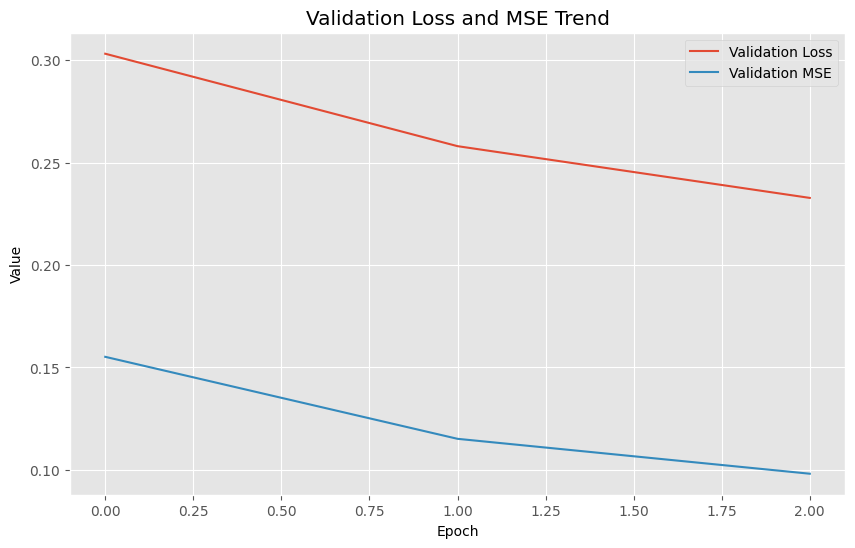

In [64]:
# Plotting the trend in validation loss and validation MSE on the same plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Validation Loss and MSE Trend')
plt.legend()
plt.show()


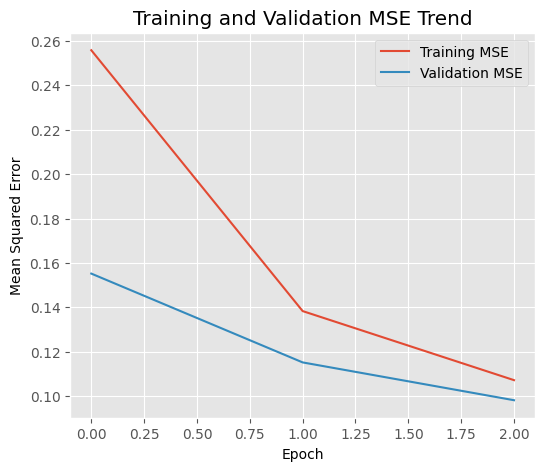

In [67]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation MSE Trend')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error

pred1 = model1.predict(X_test_scaled)
rmse1 = np.sqrt(mean_squared_error(Y_test_scaled, pred1))

62/62 [==============================] - 0s 1ms/step


In [16]:
print("RMSE for single layer, lag = 3 - ",rmse1)

RMSE for single layer, lag = 3 -  0.30895703800749597


In [17]:
#from google.colab import files
#uploaded = files.upload()
test = pd.read_csv("C:/Users/saikr/Desktop/Q4/Time Series/Final Project/final_data_2010_2023.csv")
test.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Chicago,United States",1/1/2010,-8.3,-14.5,-11.7,-15.0,-22.4,-19.0,-16.1,69.8,...,6.6,3,NaN,2010-01-01T07:18:22,2010-01-01T16:30:09,0.53,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,74466504838,..."
1,"Chicago,United States",1/2/2010,-11.4,-16.4,-14.1,-18.4,-25.3,-22.6,-19.6,63.1,...,8.5,4,NaN,2010-01-02T07:18:26,2010-01-02T16:31:02,0.57,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,74466504838,..."
2,"Chicago,United States",1/3/2010,-7.9,-17.5,-12.5,-14.7,-25.6,-20.5,-17.6,66.0,...,7.6,4,NaN,2010-01-03T07:18:28,2010-01-03T16:31:56,0.60,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,74466504838,..."
3,"Chicago,United States",1/4/2010,-7.4,-13.1,-10.2,-14.4,-21.3,-17.6,-14.6,69.8,...,3.5,2,NaN,2010-01-04T07:18:27,2010-01-04T16:32:51,0.64,Overcast,Cloudy skies throughout the day.,cloudy,"72534014819,KORD,KMDW,72530094846,74466504838,..."
4,"Chicago,United States",1/5/2010,-5.1,-9.5,-7.9,-11.7,-15.9,-14.2,-12.3,70.8,...,5.8,3,NaN,2010-01-05T07:18:25,2010-01-05T16:33:49,0.67,Overcast,Cloudy skies throughout the day.,cloudy,"72534014819,KORD,KMDW,72530094846,74466504838,..."


In [18]:
tdata = test[["datetime","tempmax","tempmin","temp"]]
tdata['datetime'] = pd.to_datetime(tdata['datetime'])
tdata.sort_values(by="datetime", inplace=True)
tdata_tmax = tdata[["datetime","tempmax"]]
tdata_tmin = tdata[["datetime","tempmin"]]
tdata_tavg = tdata[["datetime","temp"]]

C:\Users\saikr\AppData\Local\Temp\ipykernel_25504\2930983922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata['datetime'] = pd.to_datetime(tdata['datetime'])
C:\Users\saikr\AppData\Local\Temp\ipykernel_25504\2930983922.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdata.sort_values(by="datetime", inplace=True)


In [19]:
def create_tdata_for_NN(data: pandas.DataFrame, Y_var: str, lag: int) -> Tuple[np.array, np.array, np.array]:
    y = data[Y_var].tolist()
    X, Y = [], []
    if len(y) - lag <= 0:
        X.append(y)
    else:
        for i in range(len(y) - lag):
            Y.append(y[i + lag])
            X.append(y[i : (i + lag)])

    X, Y = np.array(X), np.array(Y)
    # Reshaping the X array to an LSTM input shape
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    # Creating training and test sets
    """X_train = X
    X_test = []
    Y_train = Y
    Y_test = []
    if test_ratio > 0:
        index = round(len(X) * test_ratio)
        X_train = X[: (len(X) - index)]
        X_test = X[-index:]
        Y_train = Y[: (len(X) - index)]
        Y_test = Y[-index:]"""
    return X, Y

In [20]:
lag = 3
#test_ratio = 0.25
X,Y = create_tdata_for_NN(tdata_tavg, tdata_tavg.columns[-1], lag)

In [21]:
"""
def scale_tvalues(X,Y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    #X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    scaler = StandardScaler()
    Y_scaled = scaler.fit_transform(Y.reshape(-1, 1)).reshape(Y.shape)
    #Y_test_scaled = scaler.transform(Y_test.reshape(-1, 1)).reshape(Y_test.shape)
    return X_scaled, Y_scaled
"""

'\ndef scale_tvalues(X,Y):\n    scaler = StandardScaler()\n    X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)\n    #X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)\n    scaler = StandardScaler()\n    Y_scaled = scaler.fit_transform(Y.reshape(-1, 1)).reshape(Y.shape)\n    #Y_test_scaled = scaler.transform(Y_test.reshape(-1, 1)).reshape(Y_test.shape)\n    return X_scaled, Y_scaled\n'

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y.reshape(-1, 1)).reshape(Y.shape)
Y_test_scaled = scaler.transform(Y_test.reshape(-1, 1)).reshape(Y_test.shape)

In [23]:
predf = model1.predict(X)
rmsef = np.sqrt(mean_squared_error(Y, predf))

155/155 [==============================] - 0s 2ms/step


In [24]:
rmsef

12.048814487822805

In [25]:
predf

array([[-6.665886 ],
       [-6.0012608],
       [-5.060752 ],
       ...,
       [ 4.455273 ],
       [ 4.633401 ],
       [ 4.753997 ]], dtype=float32)

In [26]:
# Predict on the new data
pred_scaled = model1.predict(X_scaled)
rmse_scaled = np.sqrt(mean_squared_error(Y_scaled, pred_scaled))

155/155 [==============================] - 0s 1ms/step


In [27]:
rmse_scaled

0.3116264820151902

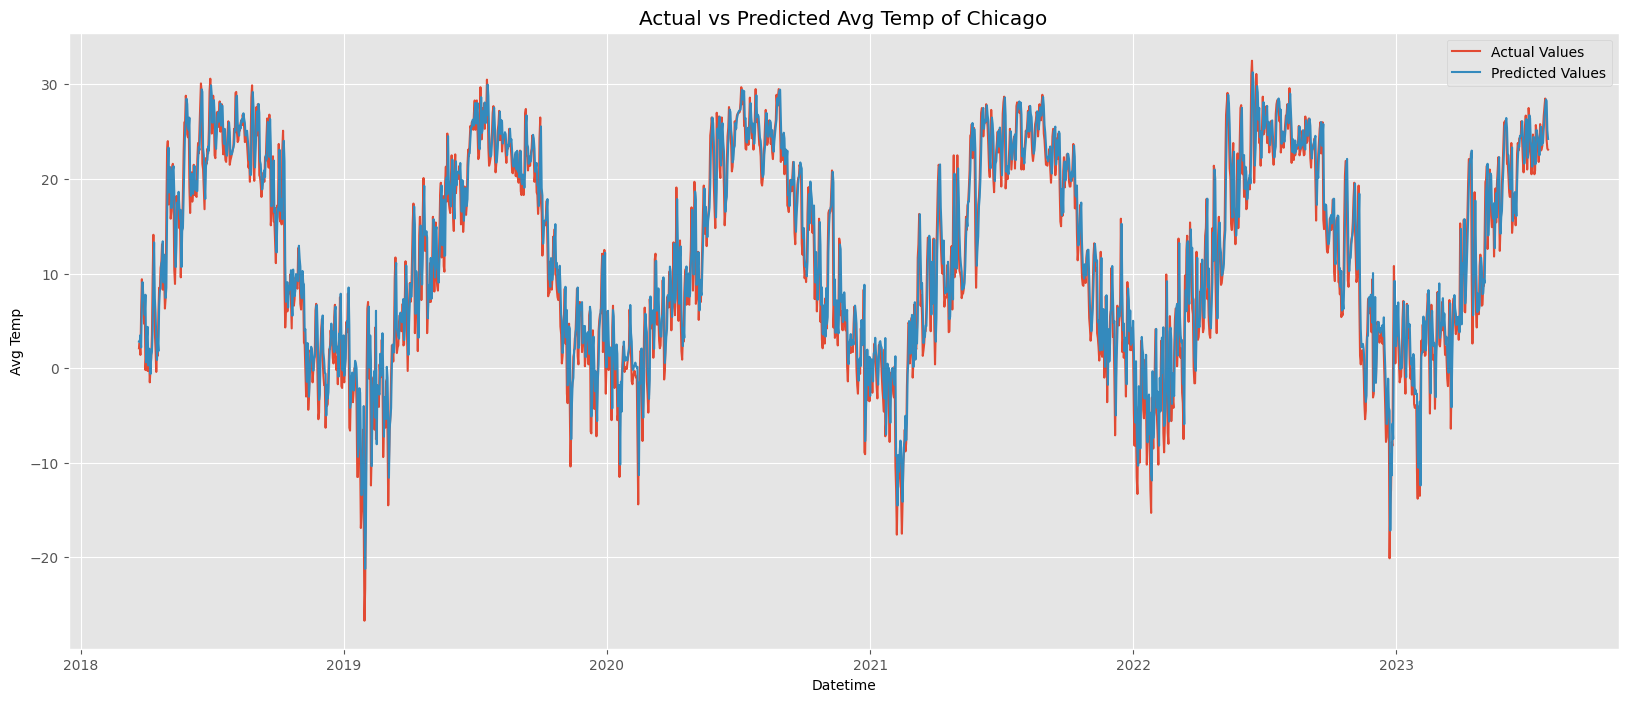

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Denormalize the scaled predictions and actual values
pred_1 = scaler.inverse_transform(predf)
pred1_denorm = scaler.inverse_transform(pred1)  # Assuming pred1_scaled is the scaled prediction array

# You also need to denormalize Y_test_scaled
Y_test_scaled_2d = Y_test_scaled.reshape(-1, 1)
Y_test_denorm = scaler.inverse_transform(Y_test_scaled_2d)

# Plotting the original values and predictions
plt.figure(figsize=(20, 8))
plt.plot(data["datetime"][-len(pred1_denorm):], Y_test_denorm, label='Actual Values')
plt.plot(data["datetime"][-len(pred1_denorm):], pred1_denorm, label='Predicted Values')
plt.xlabel('Datetime')
plt.ylabel('Avg Temp')
plt.title('Actual vs Predicted Avg Temp of Chicago')
plt.legend()
plt.show()

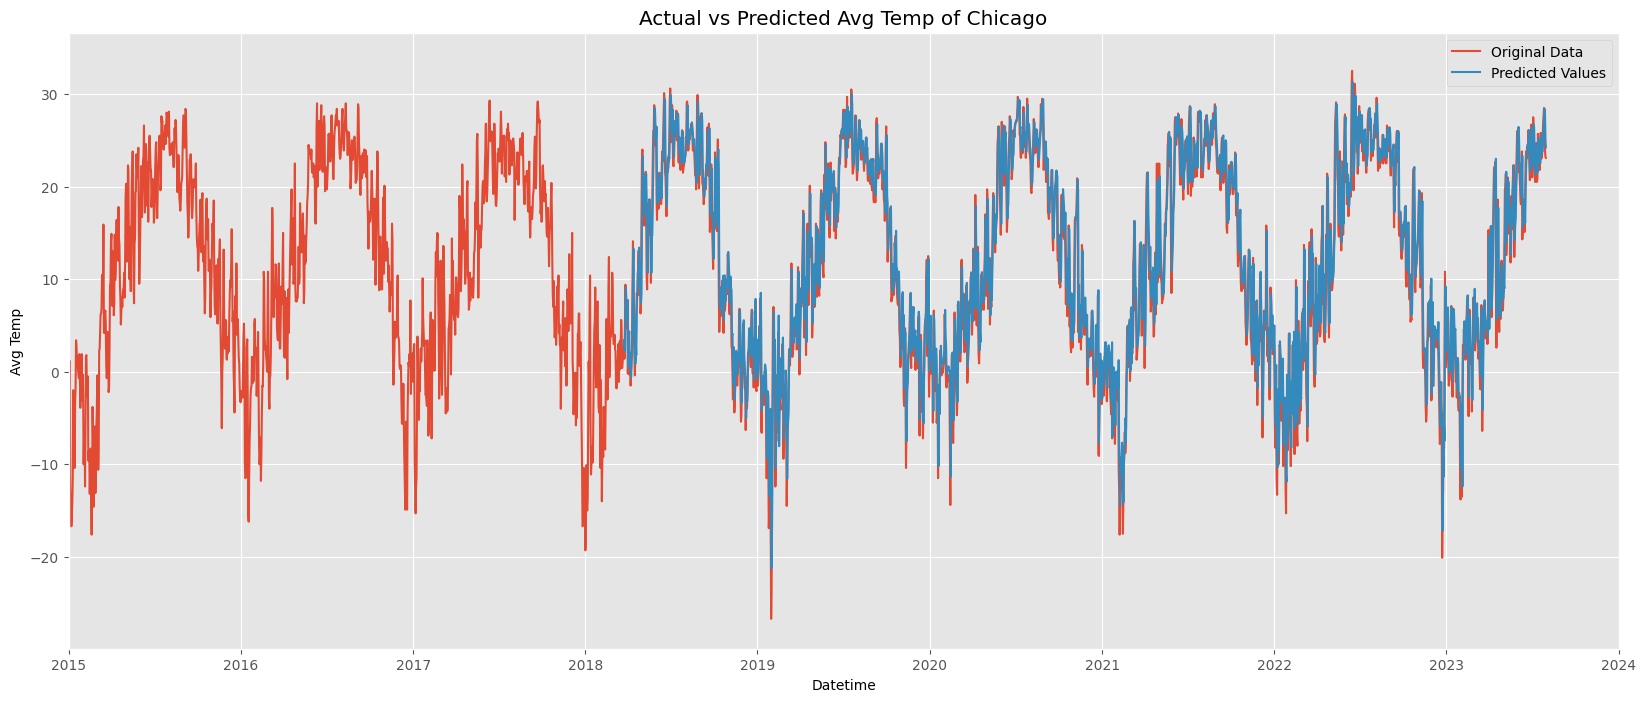

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have pred1_denorm and Y_test_denorm from the previous code

# Plotting the original values and predictions
plt.figure(figsize=(20, 8))
plt.plot(data["datetime"], data["temp"], label='Original Data')  # Assuming avg_temp is the column name of your temperature data
plt.plot(data["datetime"][-len(pred1_denorm):], pred1_denorm, label='Predicted Values')
#plt.scatter(data["datetime"][-len(Y_test_denorm):], Y_test_denorm, color='red', label='Actual Values')  # Highlighting actual values in red
plt.xlabel('Datetime')
plt.ylabel('Avg Temp')
plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2024-01-1'))  # Adjust the end date to match your data
plt.title('Actual vs Predicted Avg Temp of Chicago')
plt.legend()
plt.show()

## Extra

In [33]:
"""
plt.figure(figsize=(20, 8))
plt.plot(tdata["datetime"], tdata['tempmin'])
plt.xlabel('Datetime')
plt.ylabel('min Temp')
plt.title('Min temp of Chicago over the years')
plt.show()
"""

'\nplt.figure(figsize=(20, 8))\nplt.plot(tdata["datetime"], tdata[\'tempmin\'])\nplt.xlabel(\'Datetime\')\nplt.ylabel(\'min Temp\')\nplt.title(\'Min temp of Chicago over the years\')\nplt.show()\n'

In [48]:
lag = 3
X_new, Y_new = create_tdata_for_NN(tdata_tavg, tdata_tavg.columns[-1], lag)

X_new_scaled = scaler.transform(X_new.reshape(-1, X_new.shape[-1])).reshape(X_new.shape)
Y_new_scaled = scaler.transform(Y_new.reshape(-1, 1)).reshape(Y_new.shape)

In [49]:
# Predict on the new data
pred_new = model1.predict(X_new)
rmse_new = np.sqrt(mean_squared_error(Y_new, pred_new))

155/155 [==============================] - 0s 1ms/step


In [51]:
rmse_new

12.048814487822805

In [50]:
# Predict on the new data
pred_new_scaled = model1.predict(X_new_scaled)
rmse_new_scaled = np.sqrt(mean_squared_error(Y_new_scaled, pred_new_scaled))

155/155 [==============================] - 0s 1ms/step


In [52]:
rmse_new_scaled

0.31164945037602776

In [53]:
# Denormalize the scaled predictions and actual values for the new data
pred_new_denorm = scaler.inverse_transform(pred_new)
Y_new_scaled_2d = Y_new_scaled.reshape(-1, 1)
Y_new_denorm = scaler.inverse_transform(Y_new_scaled_2d)

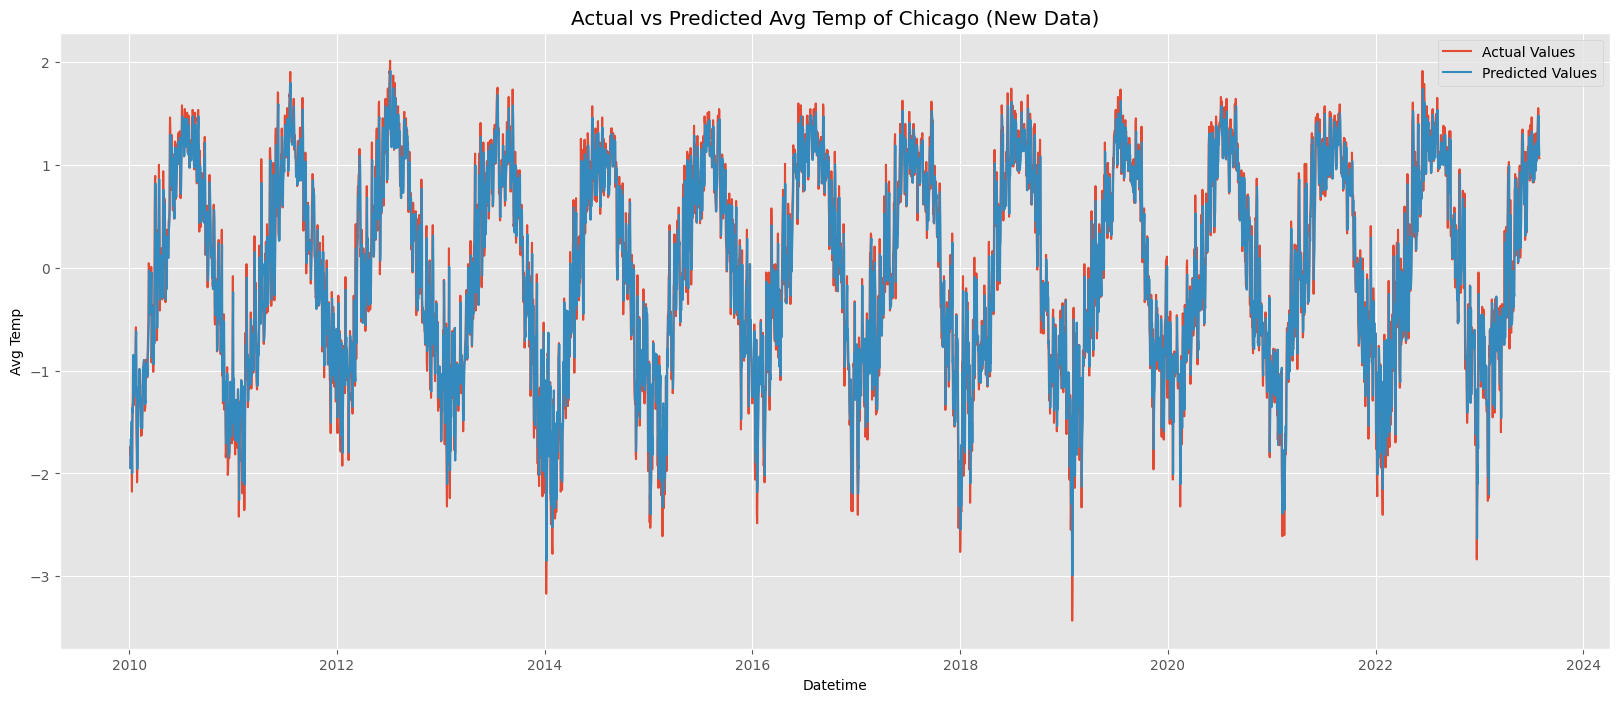

In [57]:
# Plotting the original values and predictions for the new data
plt.figure(figsize=(20, 8))
plt.plot(tdata["datetime"][-len(Y_new_scaled):], Y_new_scaled, label='Actual Values')
plt.plot(tdata["datetime"][-len(pred_new_scaled):], pred_new_scaled, label='Predicted Values')
plt.xlabel('Datetime')
plt.ylabel('Avg Temp')
plt.title('Actual vs Predicted Avg Temp of Chicago (New Data)')

# Set the x-axis limits to the range between 2015 and 2024
#plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2024-12-31'))

plt.legend()
plt.show()

In [69]:
data.head()

,datetime,tempmax,tempmin,temp
0,1970-01-01,-0.7,-4.9,-2.5
1,1970-01-02,-3.3,-6.7,-5.0
2,1970-01-03,-7.9,-12.2,-9.7
3,1970-01-04,-2.9,-15.6,-8.4
4,1970-01-05,-4.4,-13.9,-8.5


In [71]:
# Define the date range for forecasting
forecast_start_date = pd.Timestamp('2018-06-01')
forecast_end_date = pd.Timestamp('2023-07-31')

# Create a sequence of historical observations leading up to the forecast range
historical_data = data[data['datetime'] < forecast_start_date]['temp']
input_sequence = historical_data[-X_train_scaled.shape[1]:].values

# Normalize the input sequence using the same normalization parameters
input_sequence_scaled = X_test_scaled # Use the mean and std from training

# Reshape the input sequence to match the model's input shape
input_sequence_scaled = input_sequence_scaled.reshape((1, input_sequence_scaled.shape[0], 1))

# Use the trained model to make forecasts
forecasts_scaled = model1.predict(input_sequence_scaled)

# Denormalize the forecasts
forecasts = (forecasts_scaled * std_value) + mean_value

# Plot the forecasts
forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date)
plt.figure(figsize=(10, 6))
plt.plot(forecast_dates, forecasts[0], label='Forecasted Avg Temp')
plt.xlabel('Date')
plt.ylabel('Avg Temp')
plt.title('Forecasted Avg Temp using LSTM')
plt.legend()
plt.show()


ValueError: cannot reshape array of size 5871 into shape (1,1957,1)